In [1]:
from pykrx import stock
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform
import datetime
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

kospi_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
kospi_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

kosdaq_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="KOSDAQ")})
kosdaq_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))


In [2]:
today = datetime.datetime.today()
month_ago = str(today.year) + str(today.month-1) + str(today.day)
month_ago2 = str(today.year) + str(today.month-2) + str(today.day)
today = str(today.year) + str(today.month) + str(today.day)
month_ago

'20211012'

In [3]:
shrink_kospi = stock.get_market_cap_by_ticker('20211001', market='KOSPI').sort_values('시가총액', ascending=False)
shrink_kospi = shrink_kospi[0:50]
shrink_kosdaq = stock.get_market_cap_by_ticker('20211001', market='KOSDAQ').sort_values('시가총액', ascending=False)
shrink_kosdaq = shrink_kosdaq[0:50]
name1 = []
name2 = []
for ticker in shrink_kospi.index:
    name1.append(kospi_list[kospi_list['종목코드'] == ticker]['종목명'].values[0])
for ticker in shrink_kosdaq.index:
    name2.append(kosdaq_list[kosdaq_list['종목코드'] == ticker]['종목명'].values[0])
total_name = name1 + name2
len(name1), len(name2), len(total_name)
total_name.remove('현대중공업')

In [4]:
def get_name(name, fromdate, todate):
    name = name
    ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate=fromdate, todate=todate, ticker=ticker)
    df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
    df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동표준편차
    df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
    df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
    df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
    df = df[19:] # 20일 이동평균을 구했기 때문에 20번째 행부터 값이 들어가 있음
    df.insert(0, column='volatility', value=0)

    df['volatility'] = (df['upper'] - df['lower'])

    return df[::-1]


In [5]:
select0 = []
fromdate = str(20210801)
todate = str(20211001)
for name in total_name:
    if get_name(name, fromdate, todate)['Close'][0] <= (get_name(name, fromdate, todate)['ma20'][0])*1.05:
        select0.append(name) 
len(select0) 

92

In [6]:
select = []
fromdate = str(20210701)
todate = str(20211001)
for name in select0:
    mnt = get_name(name, fromdate, todate)['Close']
    if (mnt[1] > mnt[3]) & (mnt[2] > mnt[4]):
        select.append(name)

len(select)        

13

In [7]:
select2 = []
for name in select:
    cnt_moment = 0
    vol = get_name(name, fromdate, todate)['volatility']
    if (vol[1] > vol[3]) & (vol[2] > vol[4]):
        select2.append(name)

select2  


['SK이노베이션', 'KB금융', '신한지주', '하나금융지주', '삼성화재', '우리금융지주', '한화솔루션']

In [8]:
result_df = pd.DataFrame(index=[todate, 'd+1', 'd+2', 'd+3', 'd+4', 'd+5', 'd+6', 'd+7', 'd+8'], columns=select2)
# result_df.iloc[1]['SK이노베이션'] = 3
# result_df.iloc[2]['삼성화재'] = 4
result_df

,SK이노베이션,KB금융,신한지주,하나금융지주,삼성화재,우리금융지주,한화솔루션
20211001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d+8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for name in select2:
    ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate='20211001', todate='20211101', ticker=ticker)


    df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
    df1 = df.copy()
    df1.insert(0, column='f_close', value=0)
    df1.insert(0, column='proportion', value=0)  

    for i in range(1, len(df1)):
        df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
        df1['proportion'][i] =  (df1['f_close'][i] / df1['Close'][i] * 100)

    for i in range(8):
        result_df.iloc[i][name] = df1.iloc[i]['proportion']
print(df1[:5])

C:\Users\ghdak\AppData\Local\Temp/ipykernel_20824/433634298.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_20824/433634298.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['proportion'][i] =  (df1['f_close'][i] / df1['Close'][i] * 100)


            proportion  f_close   Open   High    Low  Close   Volume
날짜                                                                  
2021-10-01           0        0  44950  44950  42800  42950  1600589
2021-10-05           2     1000  43450  44550  42850  43950  2334833
2021-10-06          -1     -500  44550  45850  43300  43450  3759193
2021-10-07          -2    -1200  44250  44300  40650  42250  3532988
2021-10-08           0     -250  42150  43150  41900  42000  1442035


In [10]:
result_df

,SK이노베이션,KB금융,신한지주,하나금융지주,삼성화재,우리금융지주,한화솔루션
20211001,0,0,0,0,0,0,0
d+1,0,0,0,-1,1,0,2
d+2,-3,-1,0,0,1,0,-1
d+3,-1,2,1,1,0,1,-2
d+4,-1,-1,-1,-1,0,0,0
d+5,3,0,-1,-1,0,0,5
d+6,0,-1,0,0,0,0,1
d+7,1,1,0,0,0,0,-1
d+8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\ghdak\AppData\Local\Temp/ipykernel_20824/2609679064.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_20824/2609679064.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_20824/2609679064.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

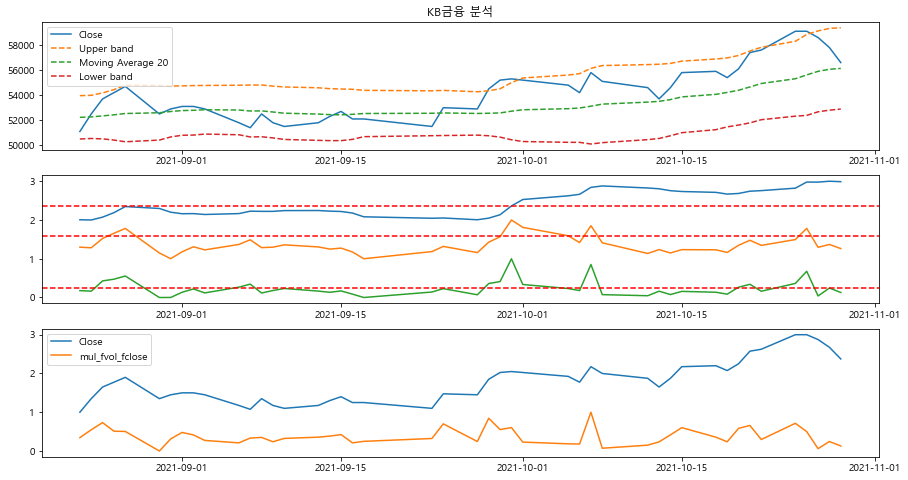

In [11]:
name = 'KB금융'
fromdate = str(20210725)
todate = str(20211030)
ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
df = stock.get_market_ohlcv_by_date(fromdate=fromdate, todate=todate, ticker=ticker)


df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
df = df[19:] # 20일 이동평균을 구했기 때문에 20번째 행부터 값이 들어가 있음
df['volatility'] = (df['upper'] - df['lower'])/2

df1 = df.copy().loc[:,('Close','ma20','volatility')]
df1.insert(0, column='f_close', value=0)
df1.insert(0, column='f_ma20', value=0)
df1.insert(0, column='f_vol', value=0)
df1.insert(0, column='ff_vol', value=0)

for i in range(1, len(df1)):
    df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
    df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
    df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
for i in range(1, len(df1)):
    df1['ff_vol'][i] = df1['f_vol'][i] - df1['f_vol'][i-1]


scaler = MinMaxScaler()
df2 = df1.copy()
df2[:] = scaler.fit_transform(df2[:])


fig, ax = plt.subplots(3,1,figsize=(15,8))

ax[0].plot(df.index, df['Close'], label='Close')
ax[0].plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
ax[0].plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
ax[0].plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
ax[0].legend(loc='best');
ax[0].set_title(f'{name} 분석')

ax[1].plot(df2['volatility']+2) 
ax[1].plot(df2['f_vol']+1)
ax[1].plot(df2['f_vol']*df2['ff_vol']) 
ax[1].axhline(df2['f_vol'].mean()+2, color='red', linestyle='--')
ax[1].axhline(df2['ff_vol'].mean()+1, color='red', linestyle='--')
ax[1].axhline((df2['ff_vol']*df2['f_vol']).mean(), color='red', linestyle='--')

ax[2].plot(df2['Close']*2 + 1)
ax[2].plot(df2['f_close'] * df2['ff_vol'])
# ax[2].plot(df2['f_close'] * df2['volatility'])

ax[2].legend(['Close', 'mul_fvol_fclose'])
plt.show()